<a href="https://colab.research.google.com/github/JoaoMouraSS/Projetos/blob/main/Analise_dos_gastos_dos_deputados_estaduais_de_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

O seguinte projeto visa a análise exploratória dos gastos dos parlamentares do estado de São Paulo.

## Fonte dos dados: 
https://www.al.sp.gov.br/dados-abertos/grupo/21;jsessionid=D351122785BD9D1FF13FCEE28C963181

# *Fluxo do Projeto*


1.   Etapa API – Criação de uma API para consumir dados públicos da ALEPS.
2.   Etapa Ingestão – Transferir os dados para  framework Pandas.
3.   Etapa Modelagem – Cruzar os dados de 2 fontes da API e criar uma análise de despesas de gastos.
4.   Etapa Armazenar – Criar um banco de dados e fazer a ingestão dos dados para futuras consultas.
5.   Analisar os Dados – Utilizar frameworks de Data Visualization para entender o que contem nos dados



In [1]:
# Consumir a api
import requests

# Ajustar os dados
import numpy as np
import pandas as pd

# Armazenar os dados
import sqlite3

# Gerar gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Ignorar filtros
from warnings import filterwarnings
filterwarnings('ignore')

# *Consumindo a api*

In [2]:
# Links
despesas = 'http://www.al.sp.gov.br/repositorioDados/deputados/despesas_gabinetes.xml'
cadastro = 'https://www.al.sp.gov.br/repositorioDados/deputados/deputados.xml'

# Pegando as informações
dados_despesas = requests.get(despesas)
dados_cadastro = requests.get(cadastro)

# Verificando o retorno da api
print(dados_despesas, dados_cadastro)

<Response [200]> <Response [200]>


# *Transformando para o objeto pd.dataframe e fazendo alterações*

In [3]:
# Convertendo os dados para um dataframe
df_despesas = pd.read_xml(dados_despesas.content)
df_cadastro = pd.read_xml(dados_cadastro.content)

# *Modelando os dados*

In [4]:
# Removendo colunas desnecessárias
df_despesas = df_despesas[['Ano','Matricula','Valor']]
df_cadastro = df_cadastro[['Matricula','Partido','NomeParlamentar']]

filtro = df_despesas.loc[(df_despesas['Ano']>=2019)]

# Agrupar o valor gasto de cada deputado por ano
analise = filtro.groupby(by = ['Ano', 'Matricula']).sum()['Valor'].reset_index()
analise = analise.pivot(index='Matricula',columns='Ano',values='Valor')
analise = analise.dropna()

# Fazer o cruzamento dos dados entre as tabelas
df_analise = pd.merge(analise,df_cadastro,how='inner',on='Matricula')

In [23]:
# Adicionando os dados sobre pib_per_capita
data = pd.read_csv('pib_per_capita.csv',encoding='utf-8')

# Deletando colunas que não serão usadas
data.drop(['Municipio','Unnamed: 4'], axis=1, inplace=True)

# Modificando a coluna PIB per capita - transformando em um int
valores = []

for i in data['PIB per Capita']:
    separado = i.split()
    sem_ponto = separado[1].replace('.','')
    valores.append(sem_ponto)
    
data['PIB per Capita'] = valores
data['PIB per Capita'] = data['PIB per Capita'].astype(int)

# Somando os valores pelo ano
pib_ano = (data.groupby(by='Ano').sum('PIB per Capita')/1000000).reset_index()

# *Armazenando os dados*

In [ ]:
# Criando o arquivo do banco de dados
banco = sqlite3.connect('banco')

# Criando um cursor
curso_banco = banco.cursor()

# Criando a tabela
tabela1 = curso_banco.execute('create table Dados (Matricula,Gastos_2019,Gastos_2020,Gastos_2021, Gastos_2022)')

# Enviando o comando
banco.commit()

# Adicionando dados para o banco de dados
for i in df_analise.values:
  curso_banco.execute(f'insert into Dados values ({i[0]},{i[1]},{i[2]},{i[3]},{i[4]})')

# Consultando os valores do banco de dados
curso_banco.execute('select * from Dados').fetchall()

# *Visualizando os dados*

### *Utilizando o Matplot Lib fiz um gráfico para analisar os gastos dos deputados do estado de São Paulo*

In [ ]:
despesas_por_ano = (df_despesas.groupby(by=['Ano']).sum()['Valor']/1000000).reset_index()
despesas_por_ano

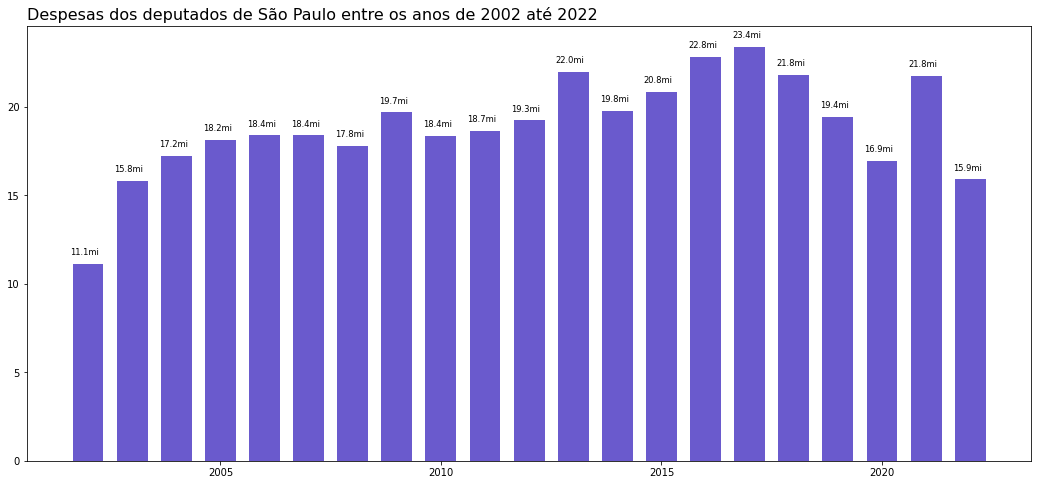

In [9]:
# Configurando a área do gráfico 
plt.figure(figsize=(18,8))

# Criando o gráfico
plt.bar( despesas_por_ano['Ano'], despesas_por_ano['Valor'], width=0.7, color='#6A5ACD')

#Ajustes
plt.title('Despesas dos deputados de São Paulo entre os anos de 2002 até 2022', loc='left', fontsize = 16, fontweight='500')
plt.style.use('ggplot')

# Adcionando valores as colunas
for i,j in enumerate(despesas_por_ano['Valor']):
  x = round(j,1)
  valores = str(x)+'mi'
  plt.text(x =despesas_por_ano['Ano'][i]-0.4,y = despesas_por_ano['Valor'][i]+0.5,s=valores, size = 'small')

# "Printando" o gráfico
plt.show()

### *Nesse gráfico, utilizando o plotly, estou querendo comparar a evoluação dos gastos e pib  per capita do estado*

In [30]:

fig = go.Figure(data=[
go.Line(name='Gasto dos deputados',y=despesas_por_ano['Valor'][0:18], x= pib_ano['Ano']), 
go.Line(name = 'PIB per capita',y=pib_ano['PIB per Capita'],x = pib_ano['Ano']),])

fig.update_layout(title='Comparação entre os gastos dos deputados e o PIB per capita')

fig.show()